# Identifying number and location of Trendi machines and facilities using k-means clustering 
* We use [constrained k-means clustering](https://pypi.org/project/k-means-constrained/#:~:text=K%2Dmeans%20clustering%20implementation%20whereby,MCF%20linear%20network%20optimisation%20problem.) identify the number and location of Trendi machines. Constrained k-means ensures that the travel distance from each machine to agricultural waste sources is optimised, while taking into account the capacity of the machines, ensuring that each machine processes roughly the same amount of waste each year. 
* Then, we use [weighted k-menas clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to identify the number and location of facilities to house the Trendi machines. Weighted k-means optimises for travel distance, but doesn't take into account capacity, because the number of machines per facility can vary. 
* Finally, we impose a maximum travel distance for facilities to determine the number of facilities required. This is similar to solving the [maximal covering location problem](https://www.tandfonline.com/doi/full/10.1080/19376812.2020.1838306#:~:text=The%20Maximal%20Covering%20Location%20Problem%20(MCLP)%20seeks%20to%20maximize%20the,to%20resolve%20the%20questions%20raised.), see example [here](https://pysal.org/spaghetti/notebooks/facility-location.html).  

In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area, plot_voronoi_polys, colors_for_voronoi_polys_and_points
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from shapely.ops import cascaded_union, unary_union
from kneed import KneeLocator
import os
import imageio

## Defining variables

In [2]:
provinces = ['bc']
weightFactor = 20 # tonnes of waste each point represents in constrained k-means
capacity = 2500 / 1000 * 365 * 5 # capacity in tonnes per year 
distLimitKm = 50 # travel distance limit for facilities 

## Data preparation

### Reading data
* `canada` - geodataframe of Canada, separated by provinces 
* `baseMap` - polygon of baseMap, to be used in Voronoi diagram 
* `gdf` - geodataframe of points, showing tonnes of agricultural waste for each location in Canada. This data was prepared in the jupyter notebooks `01_dataWrangling_1_cropProvince` and `01_dataWrangling_2_calcYield`

In [3]:
canada = gpd.read_file('data/baseMapShp/canada_albers_long.shp')
from shapely.ops import unary_union
baseMap = canada[canada.province.isin(provinces)]

In [4]:
# read shpfile for canada waste yield
gdf = gpd.read_file('data/shp/canada_wasteYield.shp')
gdf['lat'] = gdf.geometry.y
gdf['lng'] = gdf.geometry.x
gdf = gdf.reset_index()
gdf.rename(columns={'index': 'cell_id'}, inplace=True)
gdf = gdf[~gdf.waste_t.isna()]
gdf = gdf[gdf.province.isin(provinces)]
gdf = gdf[gdf.waste_t > (weightFactor / 2)] # removed all locations with a waste yield smaller than 10 tonnes

### Preparing data for spatial analysis 
* `X` - geodataframe with lat lng coordinates, showing tonnes of agricultural waste for each location in Canada. 
* `X_c` - geodataframe for constrained k-means clustering. Each point represents 20 tonnes of waste (n tonnes is determined by weightFactor). So if there is 100 tonnes on waste in one location in `X`, there will be 5 points on that location in `X_c`, each representing 20 tonnes. 

In [5]:
# make dataframes for k-means
X = pd.DataFrame(gdf[['cell_id', 'lat', 'lng', 'waste_t']])
X = X[X.waste_t > 0]
X['weight'] = round(X.waste_t / weightFactor)
X_c = X.loc[X.index.repeat(X.weight)][['cell_id', 'lat', 'lng']]
X_c['waste_t'] = weightFactor
print('each point in X_c represents {} tonnes of agricultural waste'.format(weightFactor))

each point in X_c represents 20 tonnes of agricultural waste


## Identifying number and locations of Trendi machines 
Here, we use k-means clustering to identify the number and locations of Trendi machines, minimising travel distance between each machine and source of agricultural waste. The number of machines is determined by the capacity of the machines, which can be defined in `capacity`. 

We compare two types of k-means clustering methods: weighted k-means clustering and constrained k-means clustering. 
* [weighted k-means clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) assigns points to clusters while taking weight of each point into account
* [constrained k-means clustering](https://pypi.org/project/k-means-constrained/#:~:text=K%2Dmeans%20clustering%20implementation%20whereby,MCF%20linear%20network%20optimisation%20problem.) assigns points to clusters while contraining the minimum and maximum number of points allows in each cluster. 

After the comparison, we chose constrained k-means, because this method ensures that each machine (or each cluster) has roughly the same amount waste to be processed. However, because of the additional constraint of amount of waste per cluster, the travel distance for each machine is not fully minimised like in weighted k-means. Also, constrained k-means has a much longer runtime. 

### k-means clustering for Trendi machines

In [6]:
def kMeans(gdf, X, n_clusters, weighted=True):     
    # weighted k-means clustering 
    K = n_clusters
    kmeans = KMeans(n_clusters = K, max_iter=1000, init ='k-means++')
    lat_long = X[X.columns[1:3]]
    lot_size = X[X.columns[3]] if weighted else None
    weighted_kmeans_clusters = kmeans.fit(lat_long, sample_weight = lot_size) # Compute k-means clustering.
    X['cluster_label'] = kmeans.predict(lat_long, sample_weight = lot_size)
    labels = X['cluster_label'] # Labels of each point

    gdfClus_w = pd.merge(gdf, X[['cell_id', 'cluster_label']], how='left', on='cell_id')
    gdfClus_w = gpd.GeoDataFrame(gdfClus_w)
    # gdfClus_w.cluster_label = gdfClus_w.cluster_label.astype('str')

    # cluster centers coordinates 
    centers_w = kmeans.cluster_centers_ 
    centers_w = pd.DataFrame(centers_w)
    centers_w.rename(columns={0: 'lat', 1: 'lng'}, inplace=True)
    centers_w = gpd.GeoDataFrame(centers_w, geometry=gpd.points_from_xy(centers_w.lng, centers_w.lat))
    
    return gdfClus_w, centers_w

def kMeansConstrained(gdf, X, n_clusters, size_min, size_max): 
    # compute kmeans
    clf = KMeansConstrained(n_clusters=n_clusters, size_min=size_min, size_max=size_max, random_state=0)
    lat_lng = X[X.columns[1:3]]
    clusters = clf.fit_predict(lat_lng)
    centers = clf.cluster_centers_
    labels = clf.labels_

    # make clusters gdf
    X['cluster_label'] = labels
    gdfClus = pd.merge(gdf[['cell_id', 'geometry', 'aciName']], X[['cell_id', 'cluster_label', 'waste_t']], how='left', on='cell_id')
    gdfClus = gdfClus[~gdfClus.cluster_label.isna()]
    gdfClus = gdfClus.groupby(['cell_id', 'cluster_label']).sum().reset_index()
    gdfClus = pd.merge(gdfClus, gdf[['cell_id', 'geometry']], how='left', on='cell_id')
    gdfClus = gpd.GeoDataFrame(gdfClus)

    # make centers gdf
    centers = clf.cluster_centers_
    centers = pd.DataFrame(centers)
    centers.rename(columns={0: 'lat', 1: 'lng'}, inplace=True)
    centers = gpd.GeoDataFrame(centers, geometry=gpd.points_from_xy(centers.lng, centers.lat))
    
    return gdfClus, centers

In [7]:
n_machines = int(X_c.waste_t.sum() / capacity) # n machines needed to process total waste 
size_min = int(len(X_c) / n_machines) - 5 # minimum points per cluster 
size_max = int(len(X_c) / n_machines) + 5
waste_min = size_min*weightFactor
waste_max = size_max*weightFactor

print('''
    capacity of machines: {} tonnes per year 
    total weight of waste: {} tonnes per year
    number of machines required to process waste: {} 
    each cluster will contain {} - {} tonnes of waste
'''.format(capacity, X_c.waste_t.sum(), n_machines, waste_min, waste_max))


    capacity of machines: 4562.5 tonnes per year 
    total weight of waste: 101840 tonnes per year
    number of machines required to process waste: 22 
    each cluster will contain 4520 - 4720 tonnes of waste



weighted k-means clustering of agricultural waste locations - much faster runtime, because only distance optimisation is required.

In [8]:
%%time
gdfClus_w, centers_w = kMeans(gdf, X, n_clusters=n_machines, weighted=True)

CPU times: total: 1.3 s
Wall time: 411 ms


Constrained k-means cluatering of agricultural waste locations - much slower runtime, because cluster size needs to be optimised using cost-scaling push-relabel algorithm. 

<mark>Note</mark>: I'm not sure how to estimate runtime for the whole country, because I don't know if the increase in runtime is linear or exponential. The runtime is more affected by the number of clusters (`n_machines`) than number of points to be clustered. For now, to speed up the run time, I've increased the `capacity` of the Trendi machines, which lowers the number of clusters `n_machines`

In [9]:
%%time
gdfClus_c, centers_c = kMeansConstrained(gdf, X_c, n_clusters=n_machines, size_min=size_min, size_max=size_max)

CPU times: total: 1min 1s
Wall time: 20.5 s


### Visualisation of machine locations
The maps below show the Trendi machine locations and the associated clusters of agricultural waste according to constrained k-means (left) and weighted k-means (right). 
* For constrained k-means (left), the method allocates more machines where there is more waste. Each cluster has roughly the same amount of waste (defined `capacity`), ensuring that each machine (shown as stars on map) will process roughly the same amount of waste.  
* For weighted k-means (right), the method allocates machines accordining to travel distance, but doesn't take into account the amount of waste for each cluster. This can be seen in the bar chart below the map. 

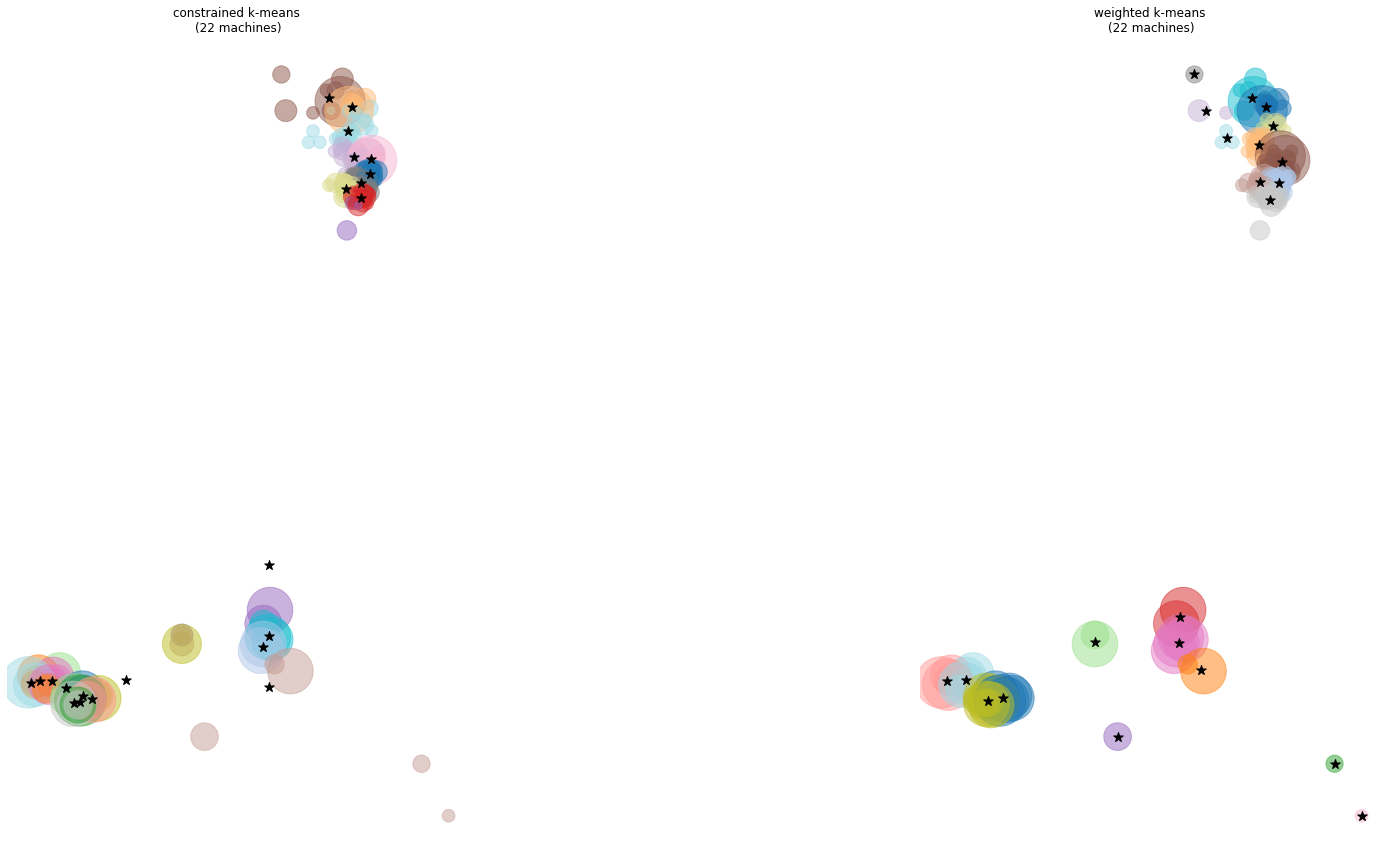

In [10]:
fig, ax = plt.subplots(1,2,figsize=(15*2,15))
for i, title in enumerate(['constrained k-means \n({} machines)'.format(n_machines), 'weighted k-means \n({} machines)'.format(n_machines)]): 
    ax[i].set_title(title)
    ax[i].axis('off')
    # baseMap.boundary.plot(ax=ax[i], color='lightgrey')
gdfClus_c.plot(ax=ax[0], column='cluster_label', cmap='tab20', markersize='waste_t', alpha=0.5)
centers_c.plot(ax=ax[0], marker='*', color='black', markersize=100)
gdfClus_w.plot(ax=ax[1], column='cluster_label', cmap='tab20', markersize='waste_t', alpha=0.5)
centers_w.plot(ax=ax[1], marker='*', color='black', markersize=100)
plt.show()

In [11]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    1,2, 
    subplot_titles=("constrained k-means (with min and max tonnes per cluster)", 
                    "weighted k-means (no constraints per cluster)"), 
    shared_yaxes=True
)

# plot constrained k-means 
temp = gdfClus_c.groupby('cluster_label').sum().waste_t.reset_index()
fig.add_trace(go.Bar(y=temp.waste_t, x=temp.cluster_label), 1, 1)
# for name, waste in {'capacity': capacity, 'min tonnes': waste_min, 'max tonnes': waste_max}.items(): 
#     fig.add_trace(go.Scatter(x=[-1,len(temp)], y=[waste, waste], mode='lines', line={'dash': 'dash', 'color': 'grey'}, name=name), row=1, col=1)
fig.add_trace(go.Scatter(x=[-1,len(temp)], y=[capacity, capacity], mode='lines', line={'dash': 'dash', 'color': 'black'}, name='capacity'), row=1, col=1)

# plot weighted k-means
temp = gdfClus_w.groupby('cluster_label').sum().waste_t.reset_index()
fig.add_trace(go.Bar(y=temp.waste_t, x=temp.cluster_label), 1, 2)
fig.add_trace(go.Scatter(x=[-1,len(temp)], y=[capacity, capacity], mode='lines', line={'dash': 'dash', 'color': 'black'}, name='capacity'), row=1, col=2)

fig.update_layout(height=500, title_text='Waste yield per cluster')
fig.show()

In the cells below, we make [voronoi diagrams](https://en.wikipedia.org/wiki/Voronoi_diagram#:~:text=In%20mathematics%2C%20a%20Voronoi%20diagram,%2C%20sites%2C%20or%20generators.) using k-means cluster centers from both weighted and constrained k-means clustering. As seen in the diagrams below, the clusters in weight k-means follows the voronoi diagram perfectly, while the clusters in the constrained k-means doesn't. 

In [12]:
def makeVoronoi(baseMap, centers): 
    boundary_shape = unary_union(baseMap.geometry)
    coords = points_to_coords(centers.geometry)
    region_polys, region_pts = voronoi_regions_from_coords(coords, boundary_shape)
    region_polys = gpd.GeoDataFrame({'geometry': list(region_polys.values())})
    return region_polys, region_pts

In [13]:
region_polys_c, region_pts_c = makeVoronoi(baseMap, centers_c)
region_polys_w, region_pts_w = makeVoronoi(baseMap, centers_w)

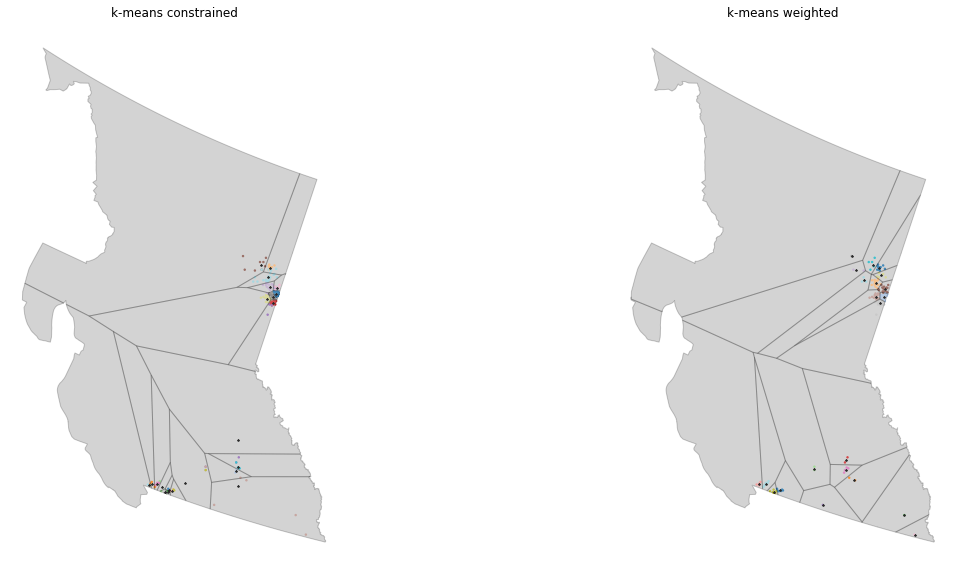

In [14]:
fig, ax = plt.subplots(1,2,figsize=(10*2,10))
for i,v in enumerate(['k-means constrained', 'k-means weighted']): 
    baseMap.plot(ax=ax[i], color='lightgrey')
    ax[i].set_title(v)
    ax[i].axis('off')
for i,gdfs in enumerate([[gdfClus_c, centers_c, region_polys_c], [gdfClus_w, centers_w, region_polys_w]]): 
    gdfs[0].plot(ax=ax[i], column='cluster_label', cmap='tab20', legend=False, markersize=2) # clusters 
    gdfs[1].plot(ax=ax[i], markersize = 3, color='black', marker='*') # centers 
    gdfs[2].plot(ax=ax[i], color='lightgrey', edgecolor='black', alpha=0.2) # voronoi 
plt.show()

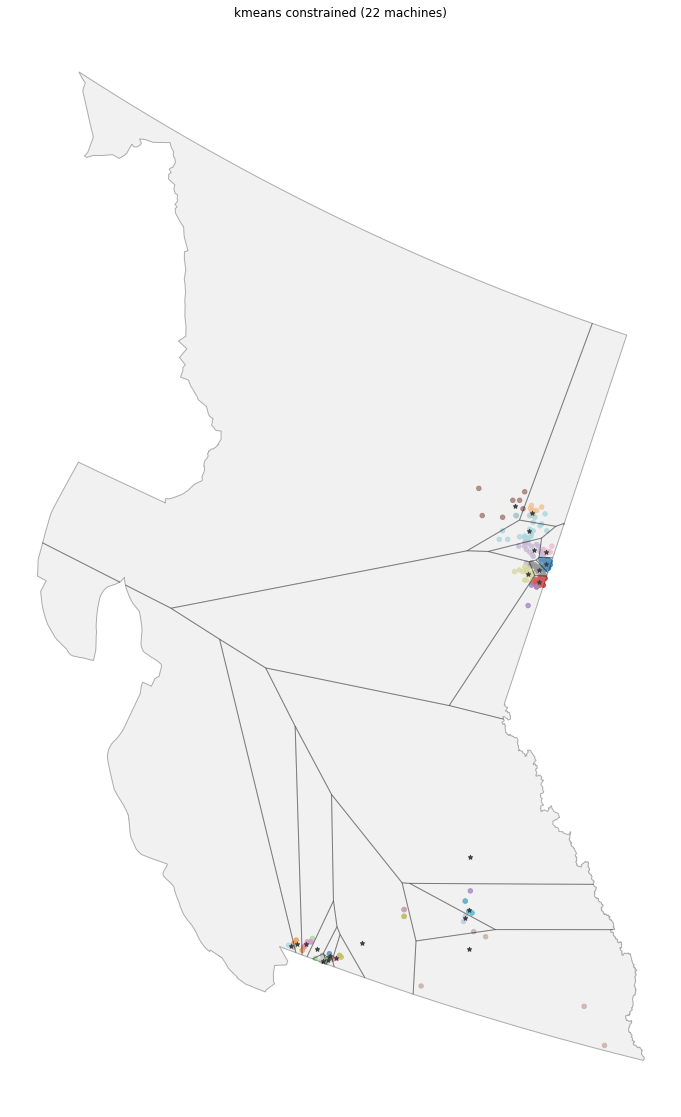

In [15]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
baseMap.plot(ax=ax, color='white')
gdfClus_c.plot(ax=ax, column='cluster_label', cmap='tab20', legend=False, markersize=20, alpha=0.8) # clusters 
centers_c.plot(ax=ax, markersize=20, color='black', marker='*') # centers 
region_polys_c.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.3) # voronoi 
ax.set_title('kmeans constrained ({} machines)'.format(n_machines))
ax.axis('off')
plt.show()

## Identifying number and locations of Trendi facilities
In the cells above, we calculated the ideal number of locations of Trendi **machines**. Now, we would like to identify the ideal number and locations of Trendi **facilities**. This will be done using standard k-means clustering of Trendi machine locations. 

We tried to identify the number of facilities in two ways: 
* [The elbow method](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/), which is one of the most popular methods to determining the number of clusters (k) for a k-means clustering analysis. 
* Setting a travel distance limit (km) for each facility with `distLimitKm`. 

In [16]:
def findIdealK(kRange, centers_c, plot=False): 
    # kmeans for kRange e.g. range(1,10)
    K_clusters = kRange
    kmeans = [KMeans(n_clusters=i) for i in K_clusters]
    Y_axis = centers_c[['lat']]
    X_axis = centers_c[['lng']]
    score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
    
    # find elbow point 
    kl = KneeLocator(K_clusters, score, curve="concave")
    n_clusters = list(kl.all_knees)[0]
    
    if plot: 
        kl.plot_knee()
    
    return n_clusters

def kMeans_facility(n_clusters, centers_c): 
    # k-means clustering 
    kmeans = KMeans(n_clusters = n_clusters, max_iter=1000, init ='k-means++')
    lat_long = centers_c[centers_c.columns[0:2]]
    weighted_kmeans_clusters = kmeans.fit(lat_long) # Compute k-means clustering.
    centers_c['cluster_label'] = kmeans.predict(lat_long)
    labels = centers_c['cluster_label'] # Labels of each point

    # cluster centers coordinates 
    centers_f = kmeans.cluster_centers_ 
    centers_f = pd.DataFrame(centers_f)
    centers_f.rename(columns={0: 'lat', 1: 'lng'}, inplace=True)
    centers_f = gpd.GeoDataFrame(centers_f, geometry=gpd.points_from_xy(centers_f.lng, centers_f.lat))
    
    return centers_f

### Determining number of facilities using elbow method
According to the elbow method, the optimum number of facilities is 2. However, this doesn't take into account the maximum travel distance for each facility.

C:\Users\tpytsui\Miniconda\envs\geo_env\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



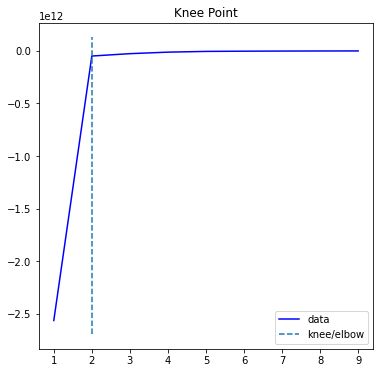

In [17]:
n_facilities = findIdealK(range(1,10), centers_c, plot=True)
centers_f = kMeans_facility(n_facilities, centers_c)

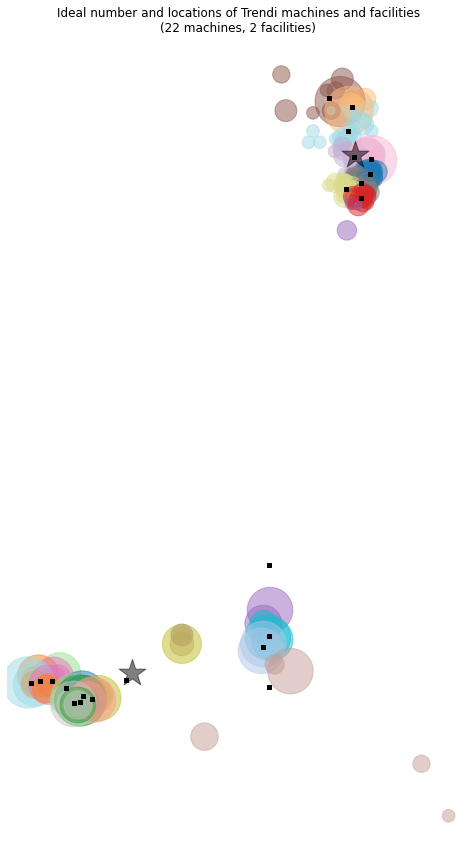

In [18]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
gdfClus_c.plot(ax=ax, column='cluster_label', cmap='tab20', markersize='waste_t', alpha=0.5)
centers_c.plot(ax=ax, color='black', marker='s', markersize=10)
centers_f.plot(ax=ax, marker='*', color='black', markersize=800, alpha=0.5)
ax.set_title('Ideal number and locations of Trendi machines and facilities\n({} machines, {} facilities)'.format(n_machines, n_facilities))
ax.axis('off')
plt.show()

### Determining number of facilities using travel distance limit
Here, we determine the number and location of facilities by setting a maximum travel distance limit for each facility.

In [19]:
def kMeans_facilities(n_clusters, centers_c): 
    # k-means clustering 
    kmeans = KMeans(n_clusters = n_clusters, max_iter=1000, init ='k-means++')
    lat_long = centers_c[centers_c.columns[0:2]]
    weighted_kmeans_clusters = kmeans.fit(lat_long) # Compute k-means clustering.
    centers_c['cluster_label'] = kmeans.predict(lat_long)
    labels = centers_c['cluster_label'] # Labels of each point

    # cluster centers coordinates 
    centers_f = kmeans.cluster_centers_ 
    centers_f = pd.DataFrame(centers_f)
    centers_f.rename(columns={0: 'lat', 1: 'lng'}, inplace=True)
    centers_f = gpd.GeoDataFrame(centers_f, geometry=gpd.points_from_xy(centers_f.lng, centers_f.lat))
    
    # find maximum distance from each point to its cluster center 
    dist = pd.DataFrame(kmeans.transform(centers_c[['lat', 'lng']]))
    dist['cluster'] = dist.apply(lambda row: row.idxmin(), axis=1)
    def findDist(row):
        cluster = row.cluster
        dist = row[cluster]
        return dist
    dist['dist'] = dist.apply(lambda row: findDist(row), axis=1)
    
    maxDistIds = []
    for cluster in dist.cluster.unique(): 
        maxDistId = dist[dist.cluster == cluster].dist.idxmax()
        maxDistIds.append(maxDistId)
        
    maxDists = dist.groupby('cluster').max().dist.reset_index()
    maxDists['maxDistId'] = maxDistIds
    maxDist = maxDists.dist.max()
    furthestPts = centers_c.iloc[maxDistIds]
    
    return centers_f, maxDist, furthestPts 

def findNClusters_distLimit(distLimitKm, plot=False): 
    n_clusters = 1
    n_clusters_list = []
    maxDists = []
    while True: 
        n_clusters = n_clusters + 1
        n_clusters_list.append(n_clusters)
        centers_f, maxDist, furthestPts = kMeans_facilities(n_clusters, centers_c)
        maxDists.append(maxDist)
        if maxDist <= distLimitKm * 1000: 
            break 
        elif n_clusters >= len(centers_c): 
            print('n clusters exceeded limit without reaching max dist')
            break
    
    if plot: 
        print('distance limit of {}km satisfied with {} clusters'.format(distLimitKm, n_clusters))
        print('max dist for {} clusters: {}km'.format(n_clusters, round(maxDist/1000)))
        plt.plot(n_clusters_list, maxDists)
        plt.plot([1.5,n_clusters_list[-1]], [distLimitKm * 1000, distLimitKm * 1000], color='black', linestyle='--')
        plt.xlabel('Number of Clusters')
        plt.ylabel('maters')
        plt.title('Maximum travel distance')
        plt.show()
        
    return n_clusters, centers_f, maxDist, furthestPts

distance limit of 50km satisfied with 7 clusters
max dist for 7 clusters: 41km


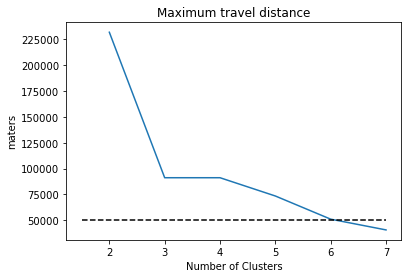

In [20]:
n_facilities, centers_f, maxDist, furthestPts = findNClusters_distLimit(distLimitKm, plot=True)

### Visualisation
Map optimal number and locations of Trendi facilities, and make gif showing how maximum travel distance affects the number and locations of Trendi facilities

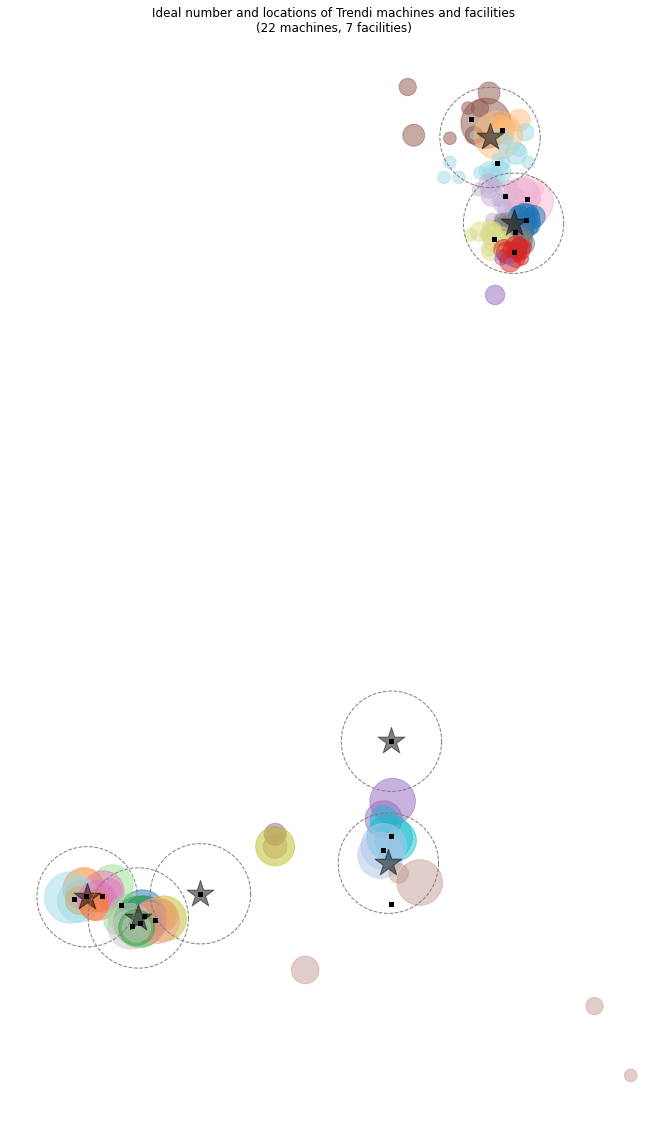

In [21]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
gdfClus_c.plot(ax=ax, column='cluster_label', cmap='tab20', markersize='waste_t', alpha=0.5)
centers_c.plot(ax=ax, color='black', marker='s', markersize=10, alpha=1)
# furthestPts.plot(ax=ax, color='red', marker='*', markersize=50)
centers_f.plot(ax=ax, color='black', marker='*', markersize=800, alpha=0.5)
centers_f.geometry.buffer(distLimitKm * 1000).boundary.plot(ax=ax, color='grey', linestyle='--', linewidth=1)
ax.set_title('Ideal number and locations of Trendi machines and facilities\n({} machines, {} facilities)'.format(n_machines, n_facilities))
ax.axis('off')
plt.show()

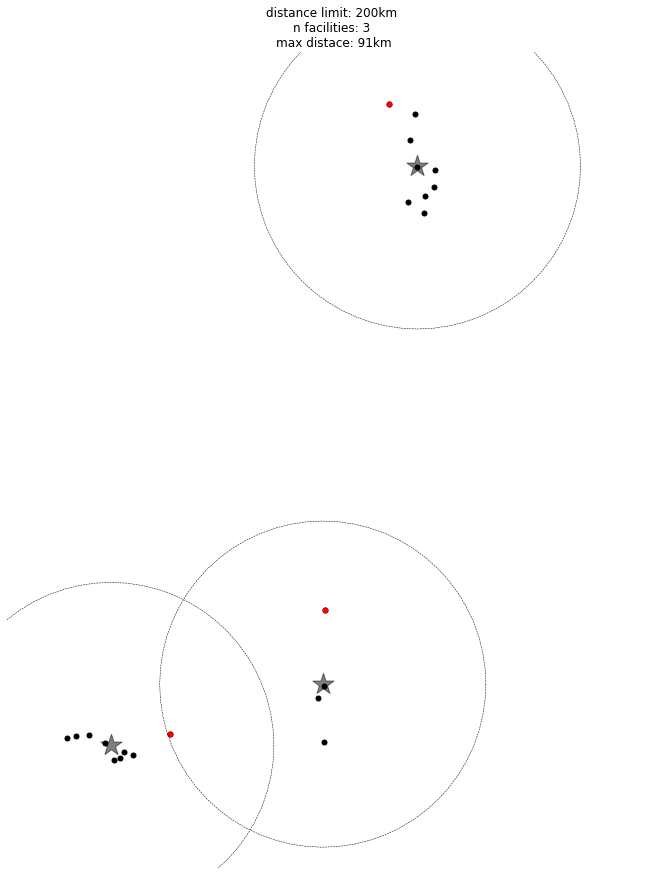

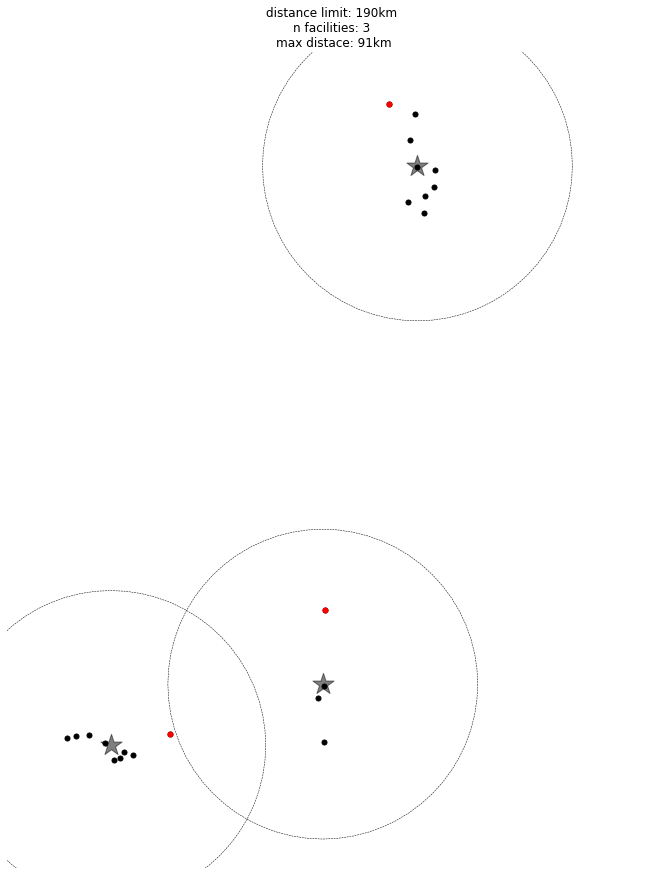

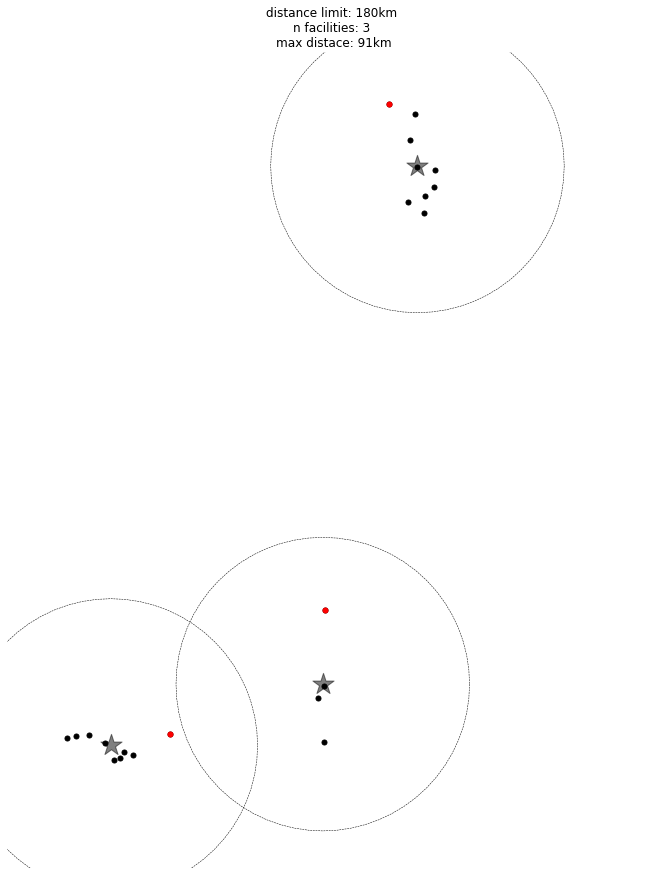

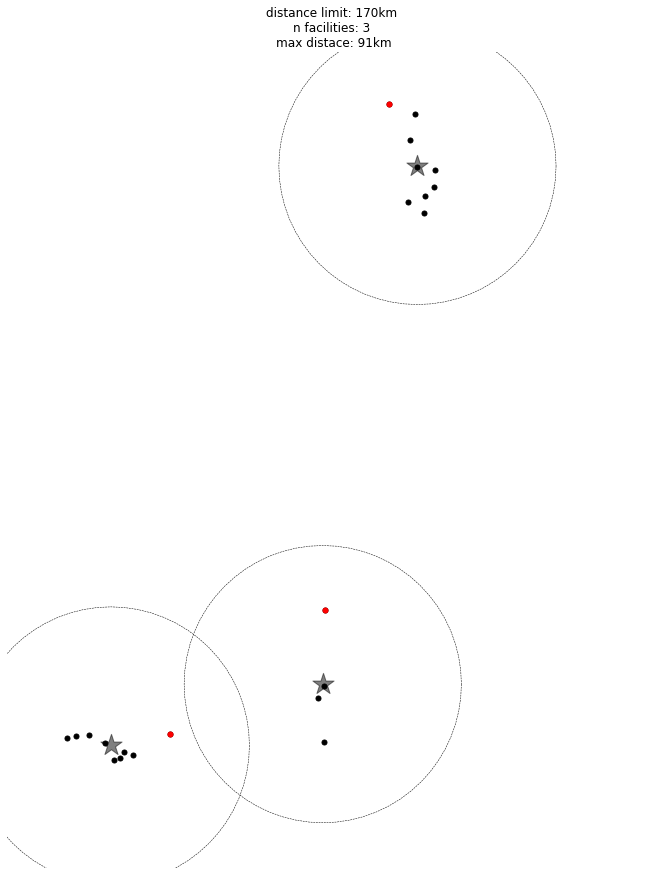

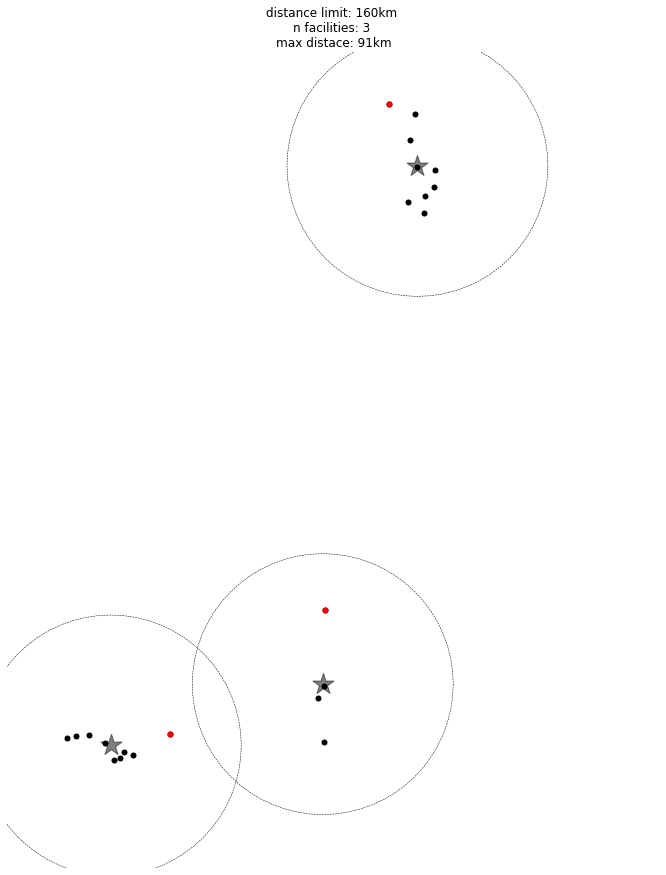

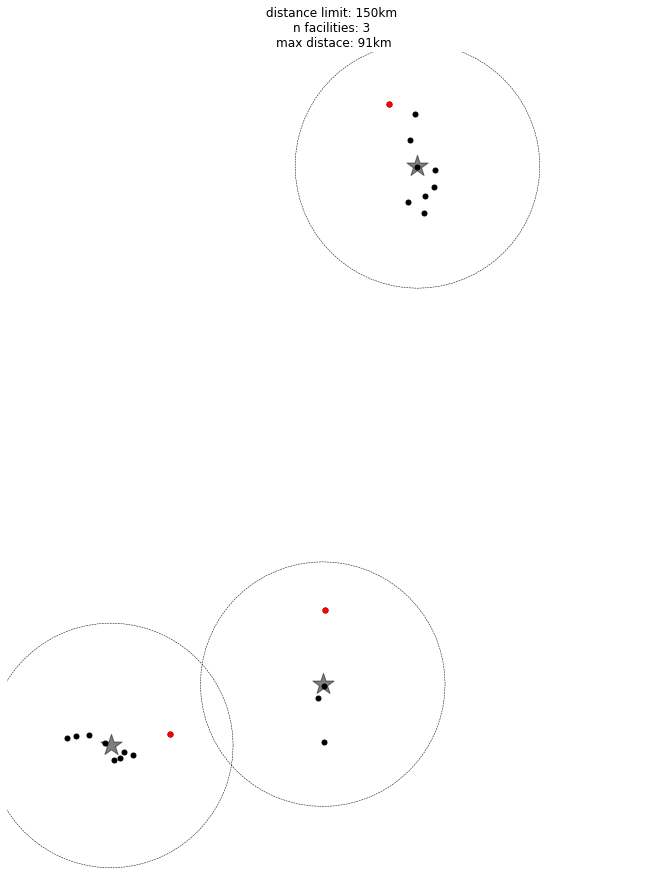

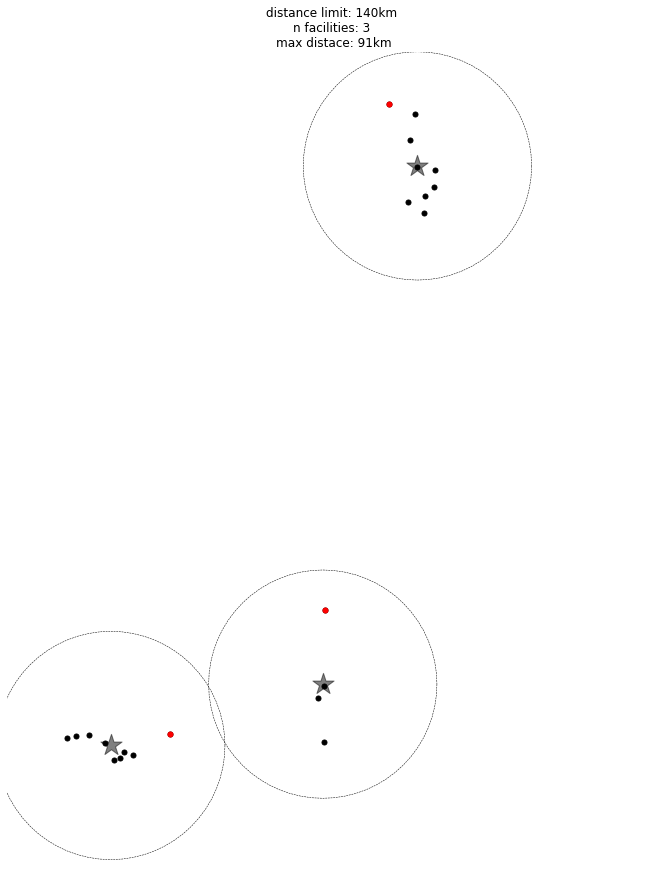

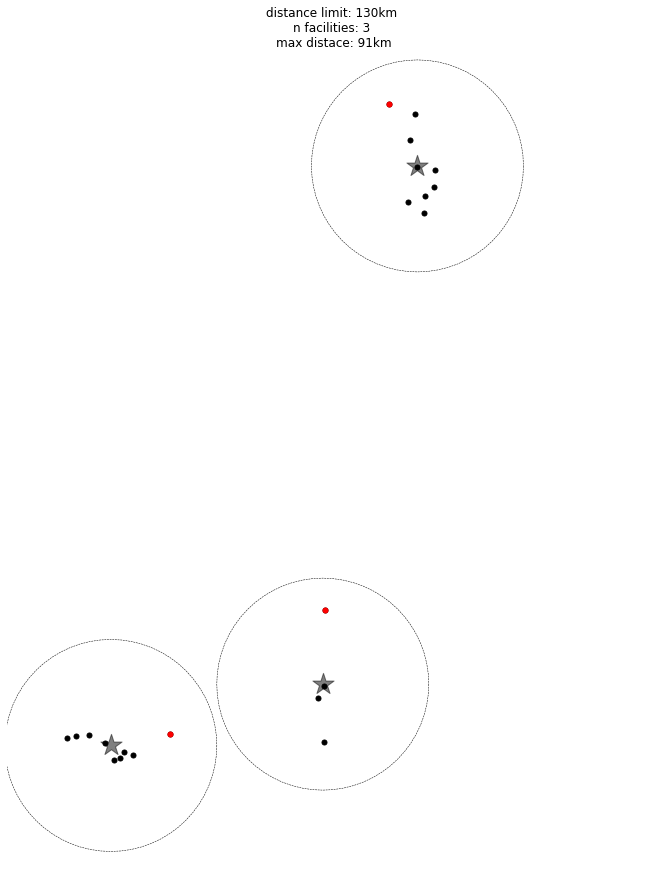

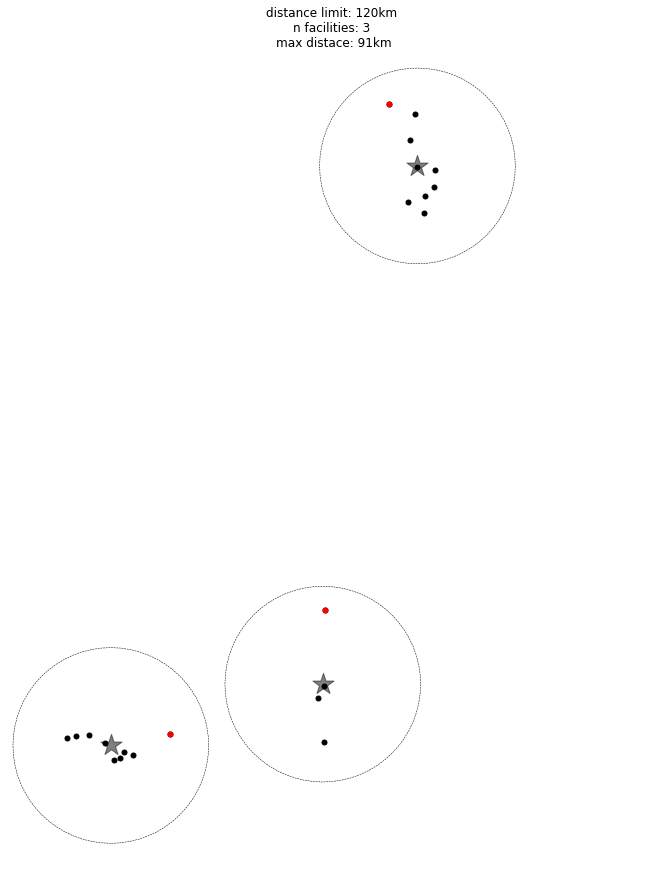

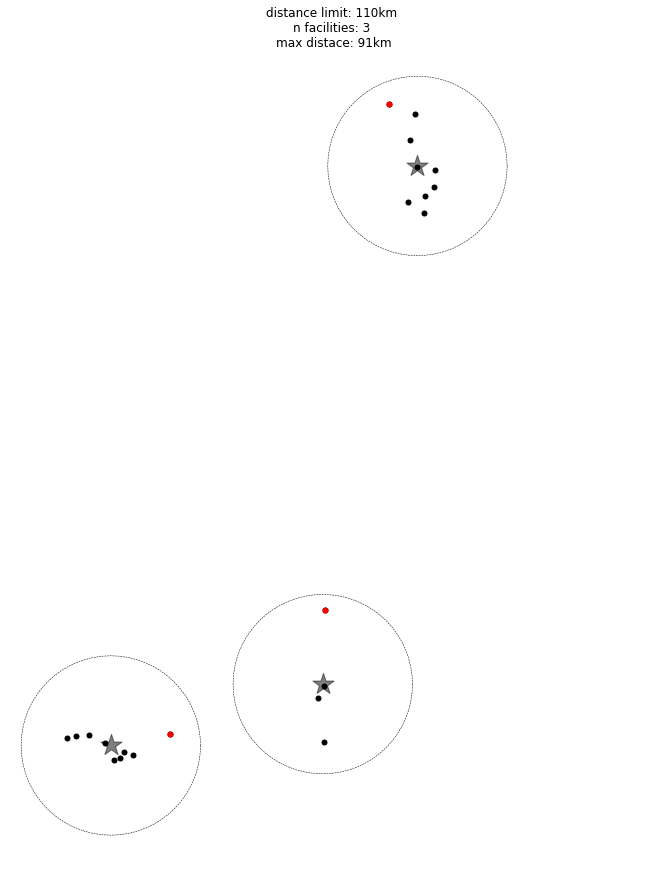

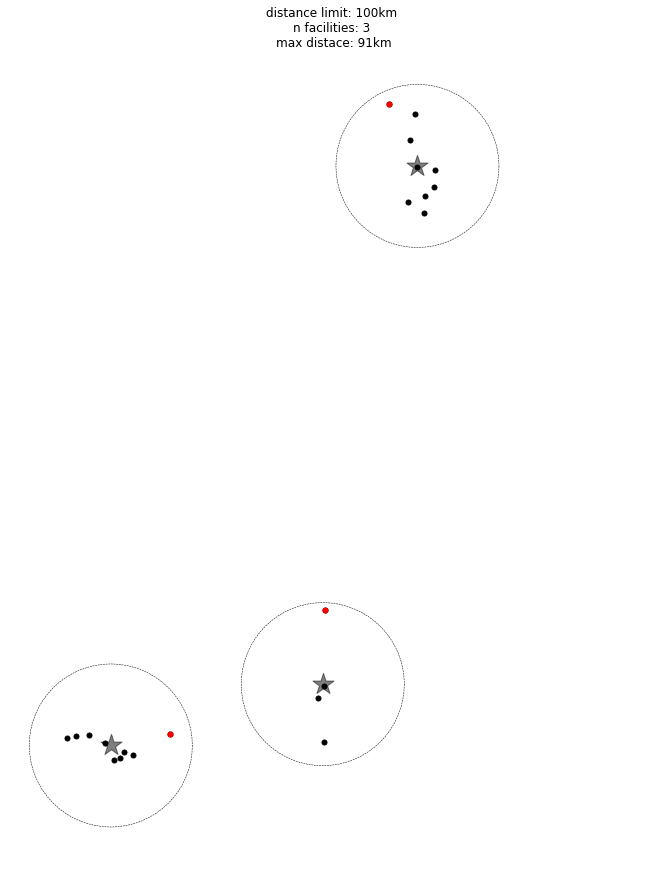

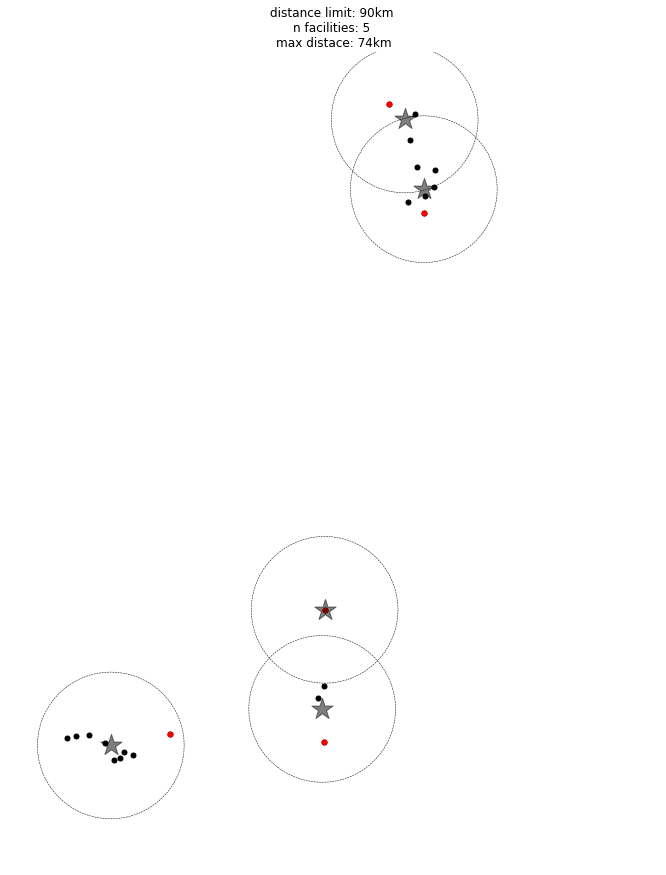

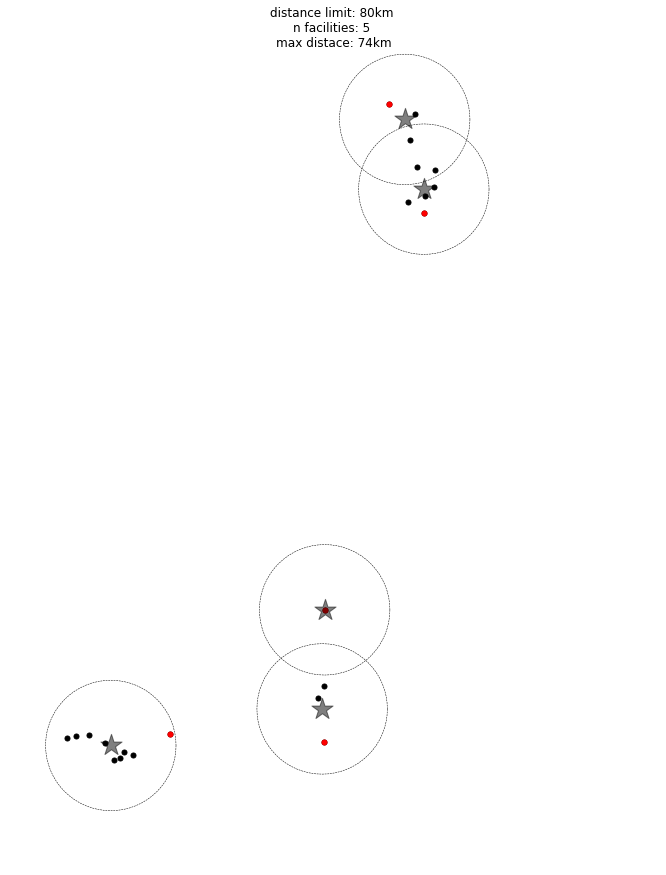

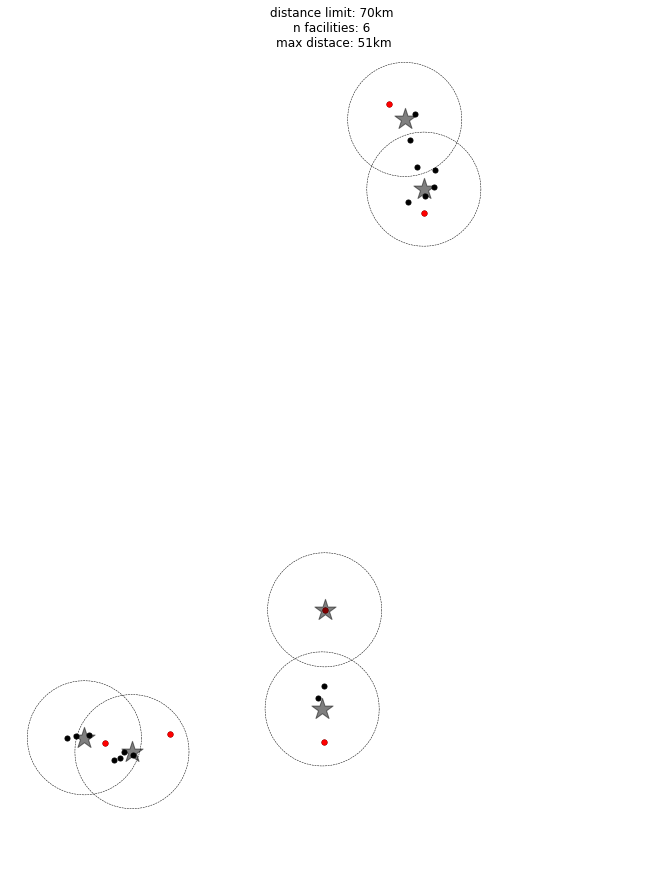

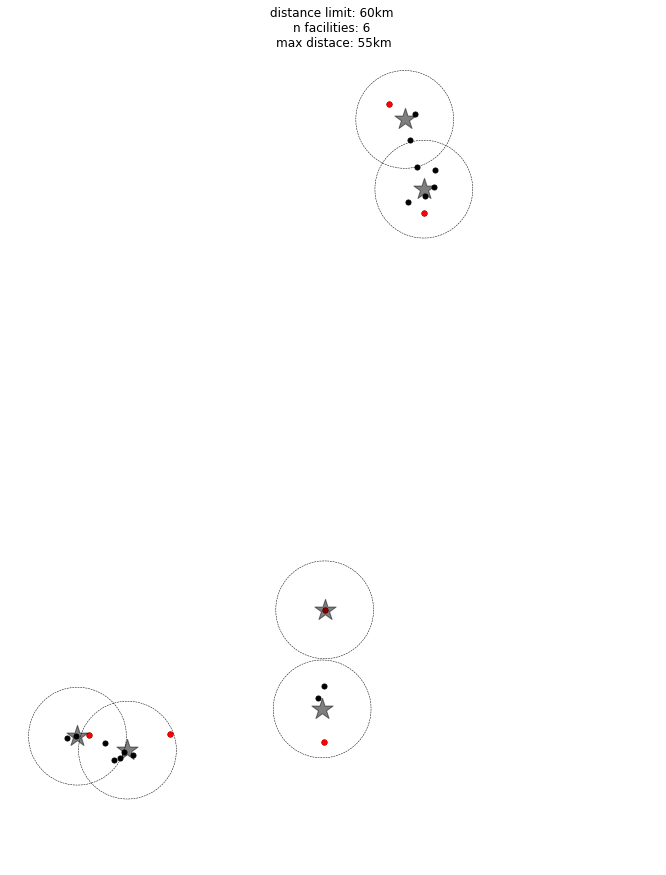

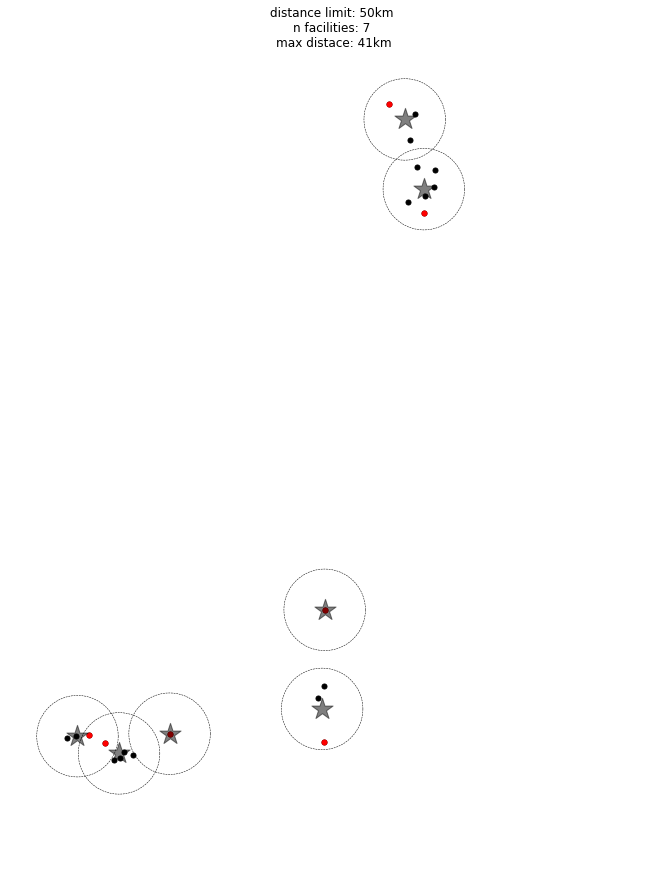

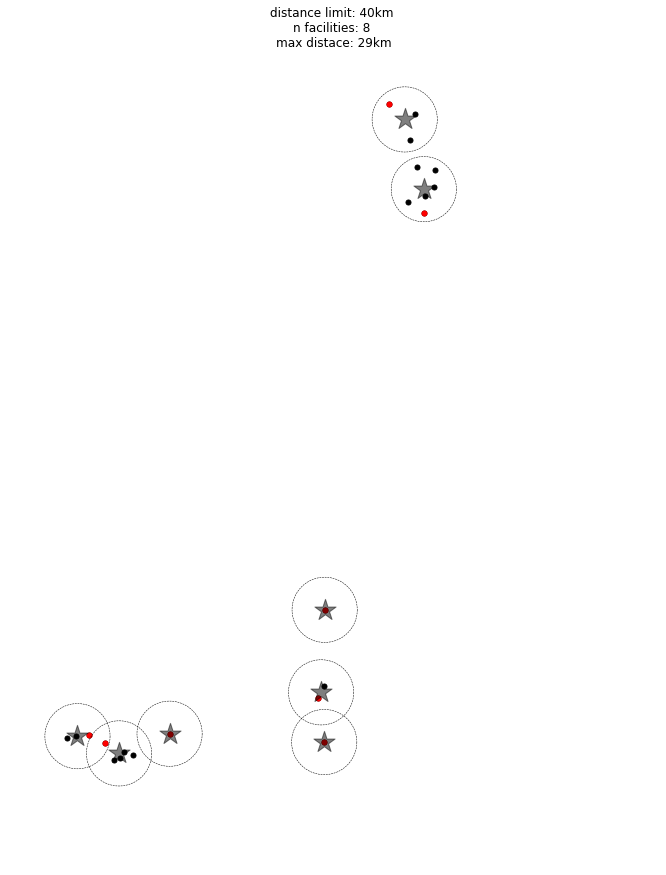

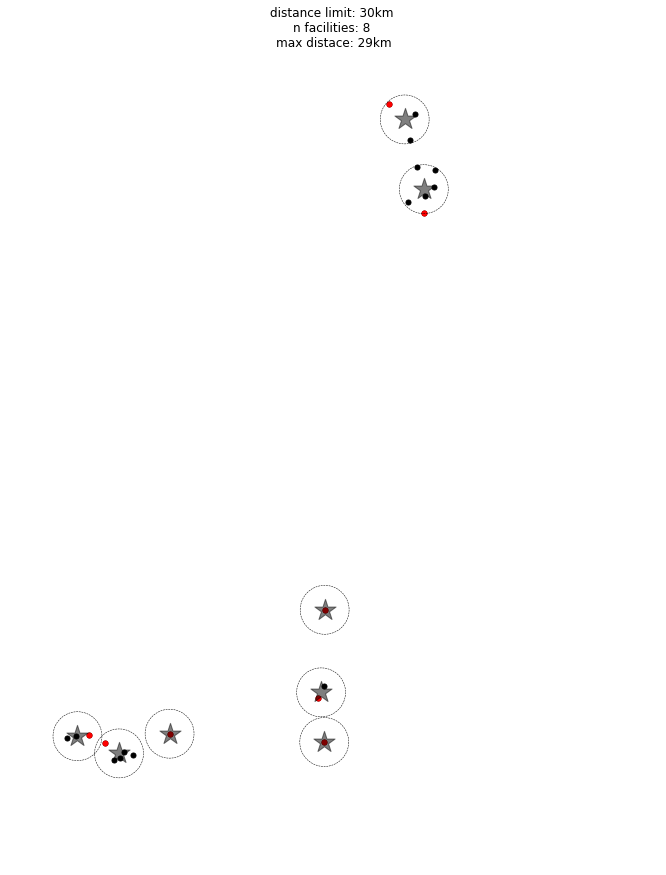

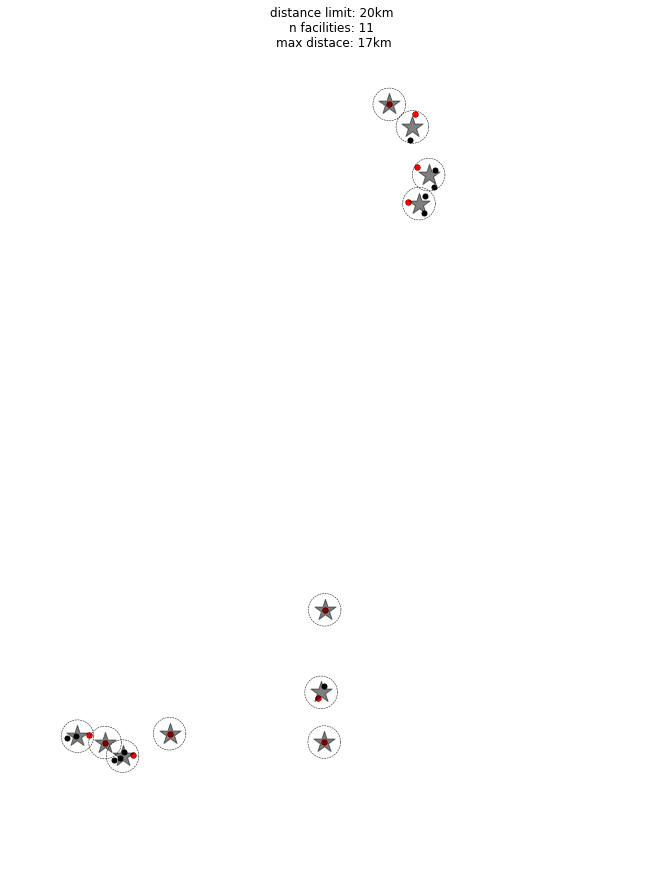

CPU times: total: 40.4 s
Wall time: 11.7 s


In [22]:
%%time 
distLimits = range(200, 10, -10)
for distLimitKm in distLimits: 
    n_facilities, centers_f, maxDist, furthestPts = findNClusters_distLimit(distLimitKm=distLimitKm, plot=False)
    
    buffers = centers_f.copy()
    buffers['bufferZone'] = buffers.geometry.buffer(distLimitKm * 1000)
    
    fig, ax = plt.subplots(1,1,figsize=(15,15))
    centers_c.plot(ax=ax, color='black', marker='.', markersize=100, alpha=1)
    furthestPts.plot(ax=ax, color='red', marker='.', markersize=100)
    centers_f.plot(ax=ax, color='black', marker='*', markersize=500, alpha=0.5)
    buffers.bufferZone.boundary.plot(ax=ax, color='black', linestyle='--', linewidth=0.5)
    ax.set_title('distance limit: {}km \nn facilities: {} \nmax distace: {}km'.format(distLimitKm, n_facilities, round(maxDist/1000)))
    ax.set_xlim(left = -2*10**6, right = -1.2*10**6)
    ax.set_ylim(top = 2.2*10**6, bottom = 1.2*10**6)
    ax.axis('off')
    plt.savefig('gif/distLimitGif_{}km'.format(str(distLimitKm).zfill(3)))
    plt.show()

In [23]:
png_dir = 'gif'
images = []
for file_name in sorted(os.listdir(png_dir), reverse=True):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('gif/test.gif', images, fps=1)

## Limitations and further work

### Limitations of data accuracy
Because the runtime for the [contrained k-means algorithm](https://pypi.org/project/k-means-constrained/) is quite long. To speed up the runtime, I simplified (and reduced the accuracy) the input data in the following ways: 
* I only run the analysis on one provine, British Columbia, which has relatively less locations of agricultural waste to begin with.
* I increased the capacity of Trendi machines by 5, in order to reduce the number of clusters the locations of waste need to be categorized into. I found that reducing the number of clusters (the 'k' in k-means) speeds up runtime a lot more than reducing the number of points to be clustered. 
* In order to run the constrained k-means algorithm, the waste data needed to be aggregated by `weightFactor`. Simply put, I needed to make a map of waste locations in Canada, where each point represented a specific amount of waste (in tonnes). In this case, I chose 20 tonnes. 
    * You can see how this reduces the accuracy of the input data: if a location has 11 tonnes of waste, it will show up as 20 tonnes on the map. 29 tonnes will also show up as 20 tonnes. The larger the `weightFactor`, the lower the accuracy.  

### Limitations of spatial analysis methods
There are also some limitations for the clustering methods we used, as shown in the points below: 
* The first step of the spatial analysis was identifying the number and locations of Trendi **machines** (see section with same title). The outcome shows the optimal locations of machines for minimizing travel distance between each machine and agricultural waste location. In reality, machines will not be placed according to this map, so it would be more helpful to interpret the map as showing how the agricultural waste locations can be clustered in a way that allows each cluster to be serviced by a machine. 
* After making clusters of agricultural waste locations for each Trendi machine, we clustered the **machine** locations to find the number and locations of **facilities**. Although we set a travel distance limit for each facility, some agricultural waste locations fall outside of the limit, because the locations of facilities was determined by the locations of **machines**, rather than the locations of **waste**. 

### Further work to increase accuracy of results
* This same notebook can be run for the whole country. This can be done by adding province codes to the variable `provice`, in the section 'defining variables'. The runtime could increase from minutes to hours. I'm not sure how to estimate runtime, because the runtime for k-means constrained doesn't seem to increase linearly. 
* The `weightFactor` can be lowered to increase accuracy, but will also increase runtime. The `weightFactor` should be determined by looking at the points with the minimum tonnes of waste in `gdf`. This depends on the extra steps required in the notebook `01_dataWrangling_2_calcYield` - matching the statsCan and aciCodes, and estimating the waste yield per crop. 
* The `capacity` of Trendi machines can be reduced to the correct capacity. This would increase runtime but produce more meaningful results for Trendi. 

### Further work to improve spatial analysis methods
* Currently, travel distance is simply measured by [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance#:~:text=In%20mathematics%2C%20the%20Euclidean%20distance,being%20called%20the%20Pythagorean%20distance.), which doesn't take into account the road network of Canada. Further work could incorporate the road network in calculating distance between facilities and machines, improving the accuracy of the section 'identifying number and locations of Trendi machines'. This could be done with the python module [spaghetti](https://pysal.org/spaghetti/notebooks/quickstart.html). 
* Currently, the only criteria used to select the facility locations is travel distance. In future work, other criteria could be added in choosing the locations of facilities. These criteria could include land price, land use, accessibility...etc. This type of analysis is called [site selection analysis](https://www.gislounge.com/how-to-perform-a-site-selection-analysis-in-arcgis-pro/#:~:text=Site%20selection%20analysis%20is%20used,key%20services%2C%20such%20as%20healthcare.). 